<a href="https://colab.research.google.com/github/alexeyporfirev/Netology-PDA-Final-project/blob/master/Final_work_PDA_PorfirevA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu  

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score

## 1. Загрузите файл HR.csv в pandas dataframe

In [ ]:
df = pd.read_csv('drive/MyDrive/pda-final-work/HR.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 2. Рассчитайте основные статистики для переменных(среднее,медиана,мода,мин/макс,сред.отклонение).

In [ ]:
# получаем набор базовых статистик, в которых есть все из требуемых величин, 
# но в них нет вычисления моды
df_stats = df.describe()
df_stats

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Определяем ф-цию вычисления моды для серии

In [ ]:
def mode_calculation(df):
  '''
  Вычисление моды для числовых столбцов  датафрейма
  :param df: Датафрейм с исходными данными
  :return: Словарь с вычисленными значениями мод для каждого числового атрибута
  '''
  modes = dict()
  for column_ in df.columns:
    if df[column_].dtype is not np.dtype('O'):
      modes[column_] = df[column_].mode()[0]
  return modes

Формируем новый датафрейм со значениями мод и добавляем его к датафрейму с базовыми статистиками

In [ ]:
df_modes = pd.DataFrame(mode_calculation(df), index=['mode'])
df_stats = df_stats.append(df_modes)

In [ ]:
df_stats

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000
mode,0.100000,0.550000,4.000000,135.000000,3.000000,0.000000,0.000000,0.000000


# 3. Рассчитайте и визуализировать корреляционную матрицу для количественных переменных.Определите две самые скоррелированные и две наименее скоррелированные переменные.

Напишем ф-цию для выделения только количественных переменных

In [ ]:
def delete_categorial_attr(df):
  '''
  Удаление из датафрейма столбцов с категориальными переменными
  :param df: Датафрейм с исходными данными
  :return: Датафрейм с удаленными столбцами категориальных переменных
  '''
  for column_ in df.columns:
    if df[column_].dtype is np.dtype('O'):
      df = df.drop([column_], axis=1)
  return df

Вызовем эту ф-цию на исходном датафрейме

In [ ]:
df_ = delete_categorial_attr(df)
df_.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
0,0.38,0.53,2,157,3,0,1,0
1,0.80,0.86,5,262,6,0,1,0
2,0.11,0.88,7,272,4,0,1,0
3,0.72,0.87,5,223,5,0,1,0
4,0.37,0.52,2,159,3,0,1,0


Построим корреляционную матрицу

In [ ]:
df_.corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


Визуализируем корреляционную матрицу

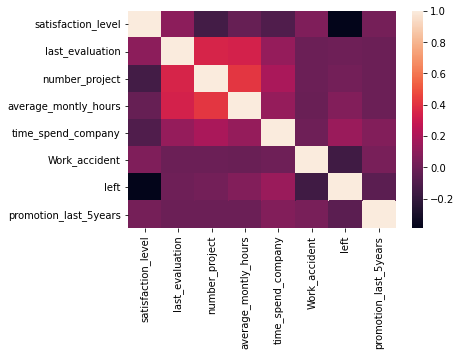

In [ ]:
sns.heatmap(df_.corr())

Напишем ф-ция для автоматического вычисления переменных с минимальной и максимальной корреляциями

In [ ]:
def find_min_max_correlation(df_, absolute_v=True):
  '''
  Функция определения двух самых скоррелированных и двух наименее
  скоррелированных переменных в датафрейме
  :param df_: Исходный датафрейм
  :param absolute_v: При поиске сравнивать коэффициенты по модулю (True)
  или нет (False)
  :return: Массив с tuple-объектами, содержащими названия двух наименее
  скоррелированных переменных и значение их коэффициента корреляции
  (первый элемент массива), и содержащими названия двух наиболее
  скоррелированных переменных и значение их коэффициента корреляции
  (второй элемент массива)
  '''
  arr = df_.corr().to_numpy()
  min_v, min_i, min_j = (abs(arr[0][1]), 0, 1)
  max_v, max_i, max_j = (abs(arr[0][1]), 0, 1)
  min_pair = tuple()
  max_pair = tuple()

  for i in range(arr.shape[0]):
    for j in range(i+1, arr.shape[0]): 
      val_ = abs(arr[i][j]) if absolute_v else arr[i][j]
      if val_ > max_v:
        max_v = val_
        max_i, max_j = (i, j)
      if val_ < min_v:
        min_v = val_
        min_i, min_j = (i, j)

  min_pair=(
      df_.columns[min_i],
      df_.corr().index[min_j],
      arr[min_i][min_j]
      )
  max_pair=(
      df_.columns[max_i],
      df_.corr().index[max_j],
      arr[max_i][max_j]
      )
  
  return [min_pair, max_pair]

In [ ]:
cor_v = find_min_max_correlation(df_, absolute_v=True)
print('Две наименее скоррелированные переменные:'
  f'\'{cor_v[0][0]}\' и \'{cor_v[0][1]}\': {cor_v[0][2]}')
print('Две наиболее скоррелированные переменные:'
  f'\'{cor_v[1][0]}\' и \'{cor_v[1][1]}\': {cor_v[1][2]}')

Две наименее скоррелированные переменные:'time_spend_company' и 'Work_accident': 0.00212041809671425
Две наиболее скоррелированные переменные:'number_project' и 'average_montly_hours': 0.4172106344017606


# 4. Рассчитайте сколько сотрудников работает в каждом департаменте.

In [ ]:
# т.к. переменная 'left' скорее всего указывает на то, ушел работник из компании
# (1) или работает в ней в данный момент (0), то сначала проводится фильтрация
# только текущих работников
df.loc[df.left==0].groupby('department')['department'].count()

department
IT              954
RandD           666
accounting      563
hr              524
management      539
marketing       655
product_mng     704
sales          3126
support        1674
technical      2023
Name: department, dtype: int64

# 5. Показать распределение сотрудников по зарплатам.

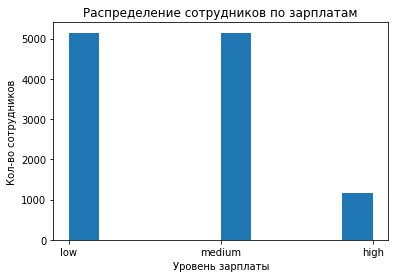

In [ ]:
# опять же смотрим только сотрудников, которые работают в данный момент, т.е.
# у которых left == 0
plt.figure(figsize=(6, 4))
plt.hist(df.loc[df.left==0].salary)
plt.title('Распределение сотрудников по зарплатам')
plt.ylabel('Кол-во сотрудников')
plt.xlabel('Уровень зарплаты')
plt.show()

# 6. Показать распределение сотрудников по зарплатам в каждом департаменте по отдельности

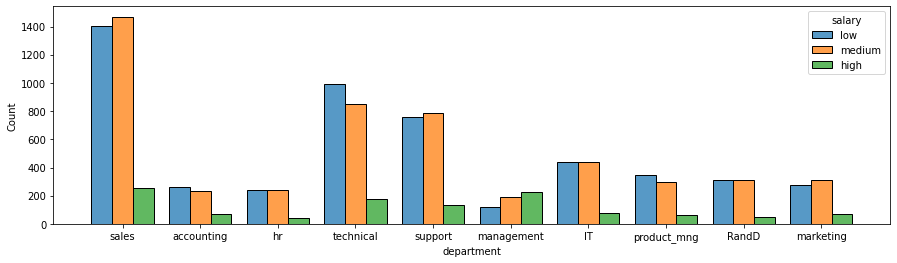

In [ ]:
# и тут также смотрим только сотрудников, которые работают в данный момент, т.е.
# у которых left == 0. если надо смотреть по всем данным, то надо указать
# data=df
plt.figure(figsize=(15, 4))
sns.histplot(data=df.loc[df.left==0], x='department', hue='salary', multiple="dodge", shrink=.8)

# 7. Проверить гипотезу, что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким окладом

Сформулируем нулевую гипотезу (H0) о том, что разницы во времени, которое сотрудники проводят на работе, для двух групп нет. Установим пороговый уровень значимости в 0.05. В данном случае у нас две независимые выборки. Будем рассматривать и уволившихся, и работающих сотрудников

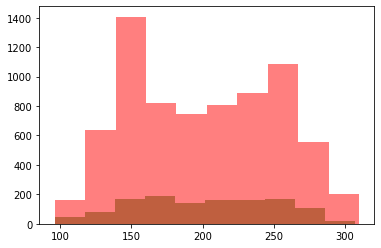

In [ ]:
emp_high_salary = df.loc[df.salary == 'high']
emp_low_salary = df.loc[df.salary == 'low']

plt.hist(emp_high_salary['average_montly_hours'], color='green', alpha=0.5)
plt.hist(emp_low_salary['average_montly_hours'], color='red', alpha=0.5)
plt.show()

Распределения в общем похожи на нормальные, но все равно применим два разных теста: t-тест Стьюдента и тест Манна-Уитни, который не требуем нормального распределения данных

In [ ]:
alpha = 0.05

t, p_value = ttest_ind(
    emp_low_salary['average_montly_hours'],
    emp_high_salary['average_montly_hours']    
    )

print('p_value =', p_value)

if p_value > alpha:
  print('Существенной разницы между исследуемыми группами нет.\n'
  'Нулевая гипотеза не может быть отвергнута')
else:
    print('Между исследуемыми группами есть существенная разница.\n'
   'Нулевая гипотеза может быть отвергнута')
    print('Сотрудники с высоким окладом проводят на работе '
    f'{"больше" if emp_high_salary.average_montly_hours.mean() > emp_low_salary.average_montly_hours.mean() else "меньше"}'
    ' времени')

print(t)

p_value = 0.4661023478267259
Существенной разницы между исследуемыми группами нет.
Нулевая гипотеза не может быть отвергнута
0.7288680398062308


In [ ]:
stat_, p_value = mannwhitneyu(
    emp_low_salary['average_montly_hours'],
    emp_high_salary['average_montly_hours']    
    )
print('p_value =', p_value)

if p_value > alpha:
  print('Существенной разницы между исследуемыми группами нет.\n'
  'Нулевая гипотеза не может быть отвергнута')
else:
    print('Между исследуемыми группами есть существенная разница.\n'
  'Нулевая гипотеза может быть отвергнута')
    print('Сотрудники с высоким окладом проводят на работе '
    f'{"больше" if emp_high_salary.average_montly_hours.mean() > emp_low_salary.average_montly_hours.mean() else "меньше"}'
    ' времени')

p_value = 0.4120665360429347
Существенной разницы между исследуемыми группами нет.
Нулевая гипотеза не может быть отвергнута


Оба теста показали, что между сотрудниками с высоким окладом и сотрудниками с низким окладом нет существенной разницы в том, какое время они проводят на работе

# 8. Рассчитать следующие показатели среди уволившихся и неуволившихся сотрудников (по отдельности):
1. Доля сотрудников с повышением за последние 5 лет
2. Средняя степень удовлетворенности
3. Среднее количество проектов

Сначала рассчитаем эти показатели для уволившихся сотрудников

In [ ]:
left_emp_with_promotion = df.loc[df.left==1].\
  promotion_last_5years.sum()/df.loc[df.left==1].promotion_last_5years.count() * 100
left_emp_mean_sat = df.loc[df.left==1].satisfaction_level.mean()
left_emp_mean_projects = df.loc[df.left==1].number_project.mean()
print(f'Доля уволившихся сотрудников с повышением за последние 5 лет: {left_emp_with_promotion:.2f}%'
  f'\nСредняя степень удовлетворенности среди уволившихся сотрудников: {left_emp_mean_sat:.2f}'
  f'\nСреднее количество проектов среди уволившихся сотрудников: {left_emp_mean_projects:.2f}'
)

Доля уволившихся сотрудников с повышением за последние 5 лет: 0.53%
Средняя степень удовлетворенности среди уволившихся сотрудников: 0.44
Среднее количество проектов среди уволившихся сотрудников: 3.86


Теперь рассчитаем эти показатели для неуволившихся сотрудников

In [ ]:
emp_with_promotion = df.loc[df.left==0].\
  promotion_last_5years.sum()/df.loc[df.left==0].promotion_last_5years.count() * 100
emp_mean_sat = df.loc[df.left==0].satisfaction_level.mean()
emp_mean_projects = df.loc[df.left==0].number_project.mean()
print(f'Доля неуволившихся сотрудников с повышением за последние 5 лет: {emp_with_promotion:.2f}%'
  f'\nСредняя степень удовлетворенности среди неуволившихся сотрудников: {emp_mean_sat:.2f}'
  f'\nСреднее количество проектов среди неуволившихся сотрудников: {emp_mean_projects:.2f}'
)

Доля неуволившихся сотрудников с повышением за последние 5 лет: 2.63%
Средняя степень удовлетворенности среди неуволившихся сотрудников: 0.67
Среднее количество проектов среди неуволившихся сотрудников: 3.79


Другой способ через группировку

In [ ]:
df_gr = df.groupby('left').agg({'satisfaction_level':'mean', 'number_project':'mean', 'promotion_last_5years': lambda x: x.sum()/x.count()*100})
df_gr.rename(index={0: "Неуволившиеся", 1: "Уволившиеся"}, inplace=True)
df_gr.columns = ['Средняя степень удовлетворенности', 'Среднее количество проектов', 'Доля сотрудников с повышением за последние 5 лет, %']
df_gr

,Средняя степень удовлетворенности,Среднее количество проектов,"Доля сотрудников с повышением за последние 5 лет, %"
left,,,
Неуволившиеся,0.666810,3.786664,2.625131
Уволившиеся,0.440098,3.855503,0.532064


#9. Разделить данные на тестовую и обучающую выборки. Построить модель LDA, предсказывающую уволился ли сотрудник на основе имеющихся факторов (кроме department и salary). Оценить качество модели на тестовой выборки

Формируем тестовую и обучающую выборки

In [ ]:
features = df_.drop(['left'], axis=1)
target = df_['left']

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=20
    )
features

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
0,0.38,0.53,2,157,3,0,0
1,0.80,0.86,5,262,6,0,0
2,0.11,0.88,7,272,4,0,0
3,0.72,0.87,5,223,5,0,0
4,0.37,0.52,2,159,3,0,0
...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0
14995,0.37,0.48,2,160,3,0,0
14996,0.37,0.53,2,143,3,0,0
14997,0.11,0.96,6,280,4,0,0


Создаем модель LDA и выполняем поиск наилучших параметров модели

In [ ]:
# создаем модель
model = LinearDiscriminantAnalysis()

# далее будем перебирать значения гиперпараметров для всего набора данных
# (и тестовых, и тренировочных), чтобы найти оптимальные значения

# определяем метод оценки качества модели
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# настраиваем параметры модели
grid = dict()
# grid['solver'] = ['svd', 'lsqr', 'eigen']
grid['solver'] = ['lsqr', 'eigen']
grid['shrinkage'] = np.arange(0, 1, 0.01)

search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)

results = search.fit(features, target)

print('Средняя точность: %.3f' % results.best_score_)
print('Оптимальные параметры: %s' % results.best_params_)

Средняя точность: 0.784
Оптимальные параметры: {'shrinkage': 0.91, 'solver': 'lsqr'}


Создаем модель с подобранными параметрами и тестируем её

In [ ]:
model = LinearDiscriminantAnalysis(solver='lsqr',  shrinkage=0.91)

model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(f'Матрица ошибок\n{confusion_matrix(y_test, prediction)}')
print( f'Точность предсказания: {accuracy_score(y_test, prediction) * 100:.2f} %')

Матрица ошибок
[[2853   24]
 [ 767  106]]
Точность предсказания: 78.91 %


In [ ]:
def get_result_df(X, y):
  df_result = pd.DataFrame({'test': y_test, 'prediction': prediction})
  for column_ in X.columns:
    df_result[column_] = X[column_]
  return df_result

df_result = get_result_df(X_test, y_test)
df_result.loc[df_result.test != df_result.prediction]

,test,prediction,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
671,1,0,0.11,0.94,6,264,4,0,0
140,1,0,0.09,0.96,6,245,4,0,0
721,1,0,0.31,0.87,4,184,3,0,0
1145,1,0,0.37,0.49,2,153,3,0,0
12247,1,0,0.46,0.49,2,148,3,0,0
...,...,...,...,...,...,...,...,...,...
1915,1,0,0.39,0.54,2,154,3,0,0
1864,1,0,0.37,0.50,2,154,3,0,0
12502,1,0,0.11,0.87,7,282,5,0,0
945,1,0,0.87,1.00,5,274,5,0,0


# 10. Загрузить jupyter notebook с решение на github и прислать ссылку